In [168]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

- age — возраст основного бенефициара;
- sex — пол страхового подрядчика;
- bmi — индекс массы тела (кгм), в идеале — от 18.5 до 24.9;
- children — количество детей, охваченных медицинской страховкой;
- smoker — является ли человек курящим;
- region — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);
- charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [169]:
data= pd.read_csv("data/insurance.zip")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [170]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [171]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


### Иследование данных

In [172]:
#Создаем копию данных
temp_data = data.copy()
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = temp_data.dtypes
num_features = list(types[(types != "object")].index)
num_features

['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'charges',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest']

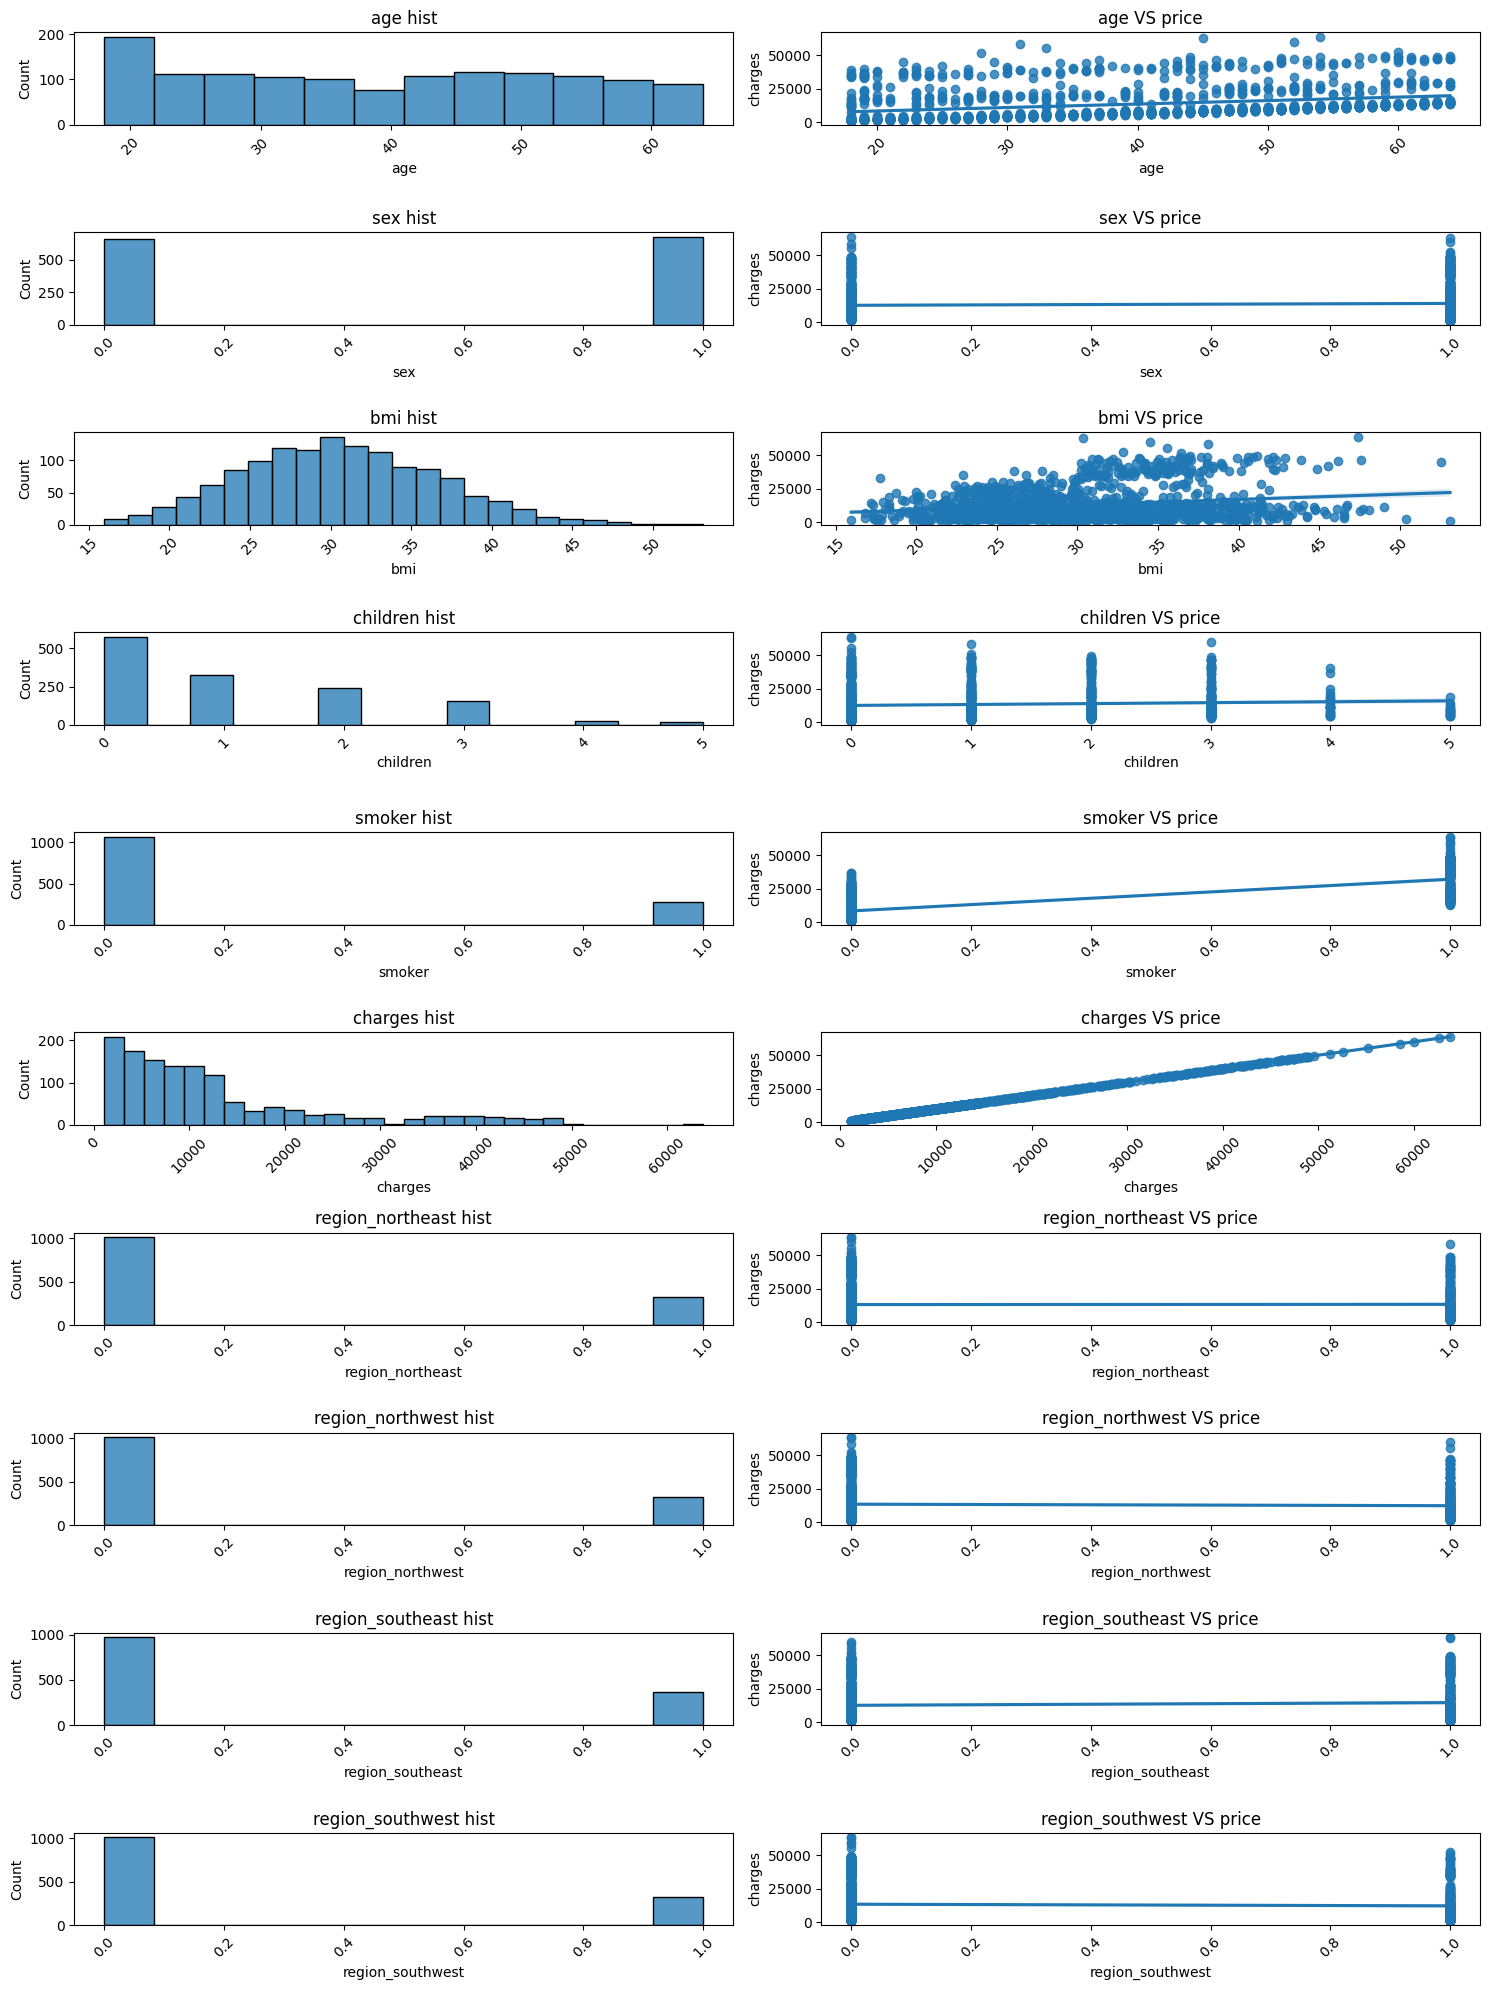

In [173]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=temp_data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=temp_data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS price'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

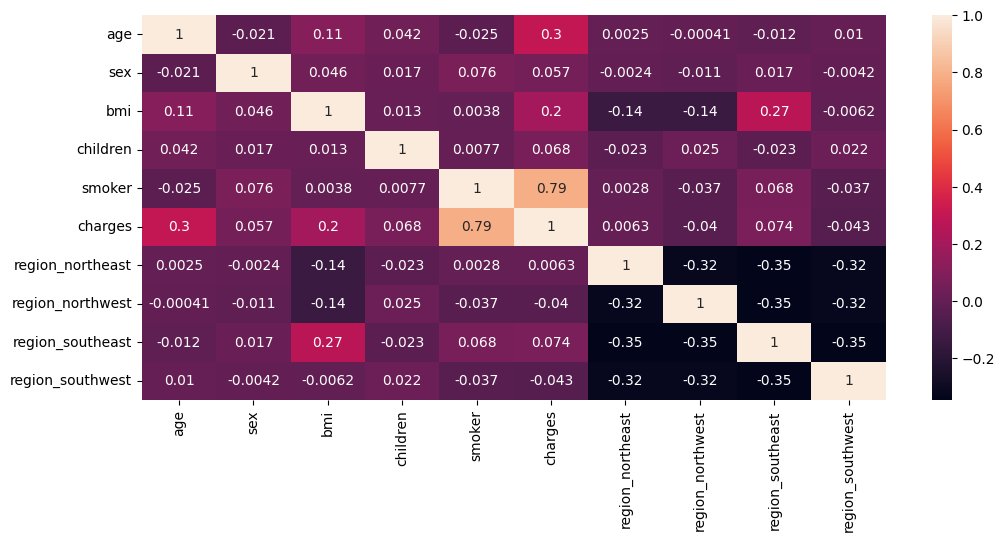

In [174]:
fig = plt.figure(figsize=(12, 5))
sns.heatmap(temp_data.corr(), annot=True);

Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков) и столбец правильных ответов y

In [175]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

Разделяем всю выборку на тренировочную и тестовую в соотношении 80/20.

На тренировочной выборке будем обучать модели, а на тестовой проверять их качество. 

In [176]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


### Моделирование + Оценка модели

Цель этапа - построить модель, решающую поставленную задачу и оценить ее качество

Заранее создадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (целевая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

In [177]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [178]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)
print(X_train_scaled_poly.shape)

(1070, 54)


In [179]:
#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lr_model_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.842
Train MAE: 2898.003
Train MAPE: 29.792


Test R^2: 0.867
Test MAE: 2732.118
Train MAPE: 30.562


In [180]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train_predict_poly)

lr_poly.coef_

array([-2.42933392e+13, -5.17873227e+13,  1.47810703e+13,  1.41886228e+12,
       -5.11885592e+13,  2.80369581e+14,  2.34372275e+14,  2.09877216e+14,
        2.16952373e+14,  8.51537109e+03,  8.47094727e+02,  1.13402734e+03,
       -1.64005078e+03,  1.66314453e+02,  2.42933392e+13,  2.42933392e+13,
        2.42933392e+13,  2.42933392e+13,  6.01599262e+13,  6.85613037e+02,
       -1.22484607e+03,  2.87566040e+02, -8.37260345e+12, -8.37260345e+12,
       -8.37260345e+12, -8.37260345e+12, -9.73849066e+03,  1.58235471e+03,
        5.48572634e+04, -1.47810703e+13, -1.47810703e+13, -1.47810703e+13,
       -1.47810703e+13, -2.04553125e+03, -2.21276562e+03, -1.41886227e+12,
       -1.41886227e+12, -1.41886227e+12, -1.41886227e+12,  9.92162943e+12,
        4.12669297e+13,  4.12669297e+13,  4.12669297e+13,  4.12669297e+13,
        1.50264126e+14,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.96261432e+14,  0.00000000e+00,  0.00000000e+00,  2.20756491e+14,
        0.00000000e+00,  

Задание 6.8
Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

Чему равны метрики R^2, MAE и MAPE на тестовой выборке?

Значение R^2 округлите до трёх знаков после запятой, а значения MAE и MAPE до целого числа.

In [181]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))
print("Test MAE: {:.3f}".format(metrics.mean_absolute_error(y_test, y_test_predict_poly)))
print("Test MAPE: {:.3f}".format(metrics.mean_absolute_percentage_error(y_test, y_test_predict_poly)*100))


Test R^2: 0.867
Test MAE: 2719.334
Test MAPE: 30.070


In [182]:
lasso_lr_poly = linear_model.Ridge()
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))
print("Test MAE: {:.3f}".format(metrics.mean_absolute_error(y_test, y_test_predict_poly)))
print("Test MAPE: {:.3f}".format(metrics.mean_absolute_percentage_error(y_test, y_test_predict_poly)*100))

Test R^2: 0.863
Test MAE: 2860.555
Test MAPE: 31.380
